# TinyML
## Tensorflow Lite를 이용한 On-Device ML 추론

### Support Devices: https://www.tensorflow.org/lite/microcontrollers

### Work Flow
1. 리눅스 서버 상에서 Tensorflow 모델 학습
2. 학습한 Tensorflow 모델을 TFLite 모델 변환
    - FP16 or INT8 Quantization 적용
3. TFLite 모델 파일을 C Source 변환
    - 리눅스 xxd 유틸리티 사용
4. 변환된 모델 파일을 사용하는 Target App 개발
    - C/C++
    - TFLite Interpreter
5. Cross Compile 하여 바이너리 실행 파일 생성
6. 바이너리 타일을 Target Device에 배포

## Enviroment Setup

- x86_64-linux-gnu
- Ubuntu 22.04.1 LTS
- gcc version 11.3.0
- python 3.10.6
- tensorflow 2.11.0

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

MODELS_DIR = 'models/'
os.makedirs(MODELS_DIR, exist_ok=True)
MODEL_TF = os.path.join(MODELS_DIR, 'model')
MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
MODEL_TFLITE_MICRO = os.path.join(MODELS_DIR, 'model.cc')

print(MODEL_TF)              # Tensorflow 모델 경로
print(MODEL_TFLITE)          # TFLite 모델 경로
print(MODEL_TFLITE_MICRO)    # MCU 디바이스를 위한 모델 경로

models/model
models/model.tflite
models/model.cc


In [6]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# 실험 재현을 위해 시드값 설정
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## 리눅스 서버 상에서 Tensorflow 모델 학습

0~2π 사이의 Sine wave를 예측하는 신경망 학습

1. 데이터셋 생성
2. 데이터셋 분할 - Train / Validation / Test
3. 학습
4. 성능 측정

## 데이터셋 생성

1. 랜덤한 X값 생성
2. 그에 대한 Sine값 계산
3. 계산된 Sine값에 대해 Noise 추가

In [7]:
# 데이터 개수
SAMPLES = 1000

# x_values: 0 to 2π 사이의 값 uniform 분포로 샘플링 
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)
np.random.shuffle(x_values)

# x값에 대한 사인 값 계산
y_values = np.sin(x_values).astype(np.float32)

print(x_values.shape)
print(x_values[:5])

print(y_values.shape)
print(y_values[:5])

(1000,)
[3.5250568 3.3671365 3.320874  3.4734828 5.3714824]
(1000,)
[-0.37413532 -0.22363645 -0.17832246 -0.32583064 -0.7905478 ]


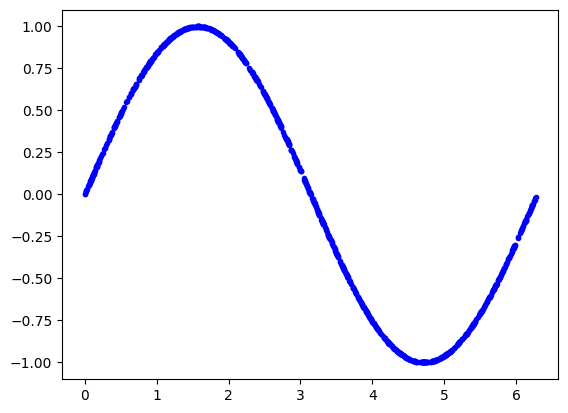

In [8]:
# Plot Data 
# 'b.' => blue dot
plt.plot(x_values, y_values, 'b.')
plt.show()

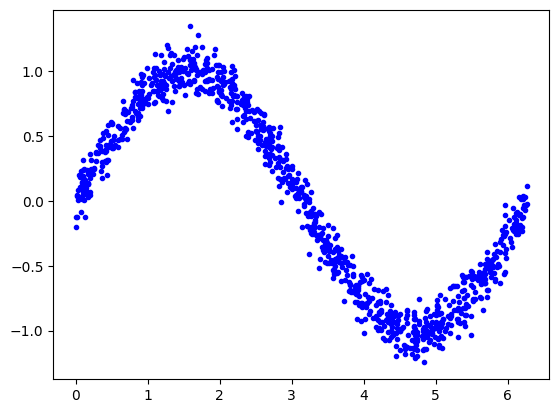

In [9]:
# y값에 작은 noise 추가
y_values += 0.1 * np.random.randn(y_values.shape[0])

# Plot Data
plt.plot(x_values, y_values, 'b.')
plt.show()

## 데이터셋 분할

1. Training: 60%
2. Validation: 20%
3. Testing: 20%

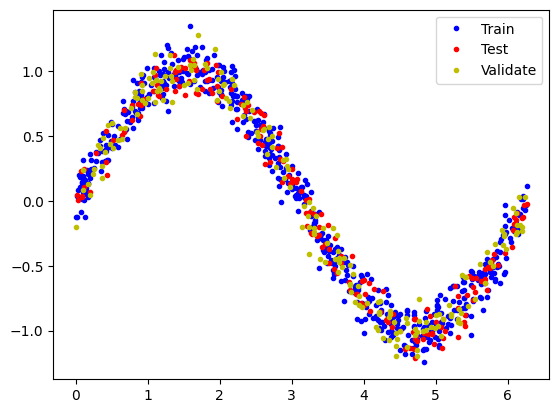

In [10]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

## 학습
1. 2 레이어 FC 신경망 생성
2. 생성한 데이터셋으로 모델 학습
3. 학습 Epoch별 MSE, MAE Plot

In [11]:
# 2 레이어 FC 신경망 생성
model = tf.keras.Sequential()

model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(keras.layers.Dense(16, activation='relu'))

# 출력 레이어, 1개 값 출력
model.add(keras.layers.Dense(1))

# 회귀를 위한 MSE Loss
# Adam Optimizer
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Tensorflow 모델 학습
history = model.fit(x_train, y_train, epochs=512, batch_size=64, validation_data=(x_validate, y_validate), verbose=0)

# Tensorflow 모델 저장
model.save(MODEL_TF)

Epoch 1/512
10/10 - 0s - loss: 0.0138 - mae: 0.0933 - val_loss: 0.0131 - val_mae: 0.0922 - 66ms/epoch - 7ms/step
Epoch 2/512
10/10 - 0s - loss: 0.0140 - mae: 0.0943 - val_loss: 0.0135 - val_mae: 0.0937 - 44ms/epoch - 4ms/step
Epoch 3/512
10/10 - 0s - loss: 0.0146 - mae: 0.0962 - val_loss: 0.0130 - val_mae: 0.0929 - 43ms/epoch - 4ms/step
Epoch 4/512
10/10 - 0s - loss: 0.0144 - mae: 0.0958 - val_loss: 0.0127 - val_mae: 0.0912 - 39ms/epoch - 4ms/step
Epoch 5/512
10/10 - 0s - loss: 0.0143 - mae: 0.0949 - val_loss: 0.0136 - val_mae: 0.0941 - 39ms/epoch - 4ms/step
Epoch 6/512
10/10 - 0s - loss: 0.0142 - mae: 0.0956 - val_loss: 0.0128 - val_mae: 0.0924 - 39ms/epoch - 4ms/step
Epoch 7/512
10/10 - 0s - loss: 0.0140 - mae: 0.0948 - val_loss: 0.0126 - val_mae: 0.0912 - 37ms/epoch - 4ms/step
Epoch 8/512
10/10 - 0s - loss: 0.0139 - mae: 0.0935 - val_loss: 0.0131 - val_mae: 0.0921 - 37ms/epoch - 4ms/step
Epoch 9/512
10/10 - 0s - loss: 0.0137 - mae: 0.0929 - val_loss: 0.0126 - val_mae: 0.0912 - 38ms/

Epoch 73/512
10/10 - 0s - loss: 0.0138 - mae: 0.0941 - val_loss: 0.0129 - val_mae: 0.0918 - 42ms/epoch - 4ms/step
Epoch 74/512
10/10 - 0s - loss: 0.0136 - mae: 0.0926 - val_loss: 0.0125 - val_mae: 0.0909 - 42ms/epoch - 4ms/step
Epoch 75/512
10/10 - 0s - loss: 0.0138 - mae: 0.0938 - val_loss: 0.0128 - val_mae: 0.0923 - 43ms/epoch - 4ms/step
Epoch 76/512
10/10 - 0s - loss: 0.0139 - mae: 0.0940 - val_loss: 0.0132 - val_mae: 0.0929 - 43ms/epoch - 4ms/step
Epoch 77/512
10/10 - 0s - loss: 0.0138 - mae: 0.0938 - val_loss: 0.0133 - val_mae: 0.0932 - 44ms/epoch - 4ms/step
Epoch 78/512
10/10 - 0s - loss: 0.0142 - mae: 0.0947 - val_loss: 0.0128 - val_mae: 0.0922 - 42ms/epoch - 4ms/step
Epoch 79/512
10/10 - 0s - loss: 0.0137 - mae: 0.0934 - val_loss: 0.0131 - val_mae: 0.0922 - 43ms/epoch - 4ms/step
Epoch 80/512
10/10 - 0s - loss: 0.0140 - mae: 0.0940 - val_loss: 0.0125 - val_mae: 0.0910 - 44ms/epoch - 4ms/step
Epoch 81/512
10/10 - 0s - loss: 0.0137 - mae: 0.0931 - val_loss: 0.0128 - val_mae: 0.091

Epoch 145/512
10/10 - 0s - loss: 0.0137 - mae: 0.0934 - val_loss: 0.0125 - val_mae: 0.0907 - 44ms/epoch - 4ms/step
Epoch 146/512
10/10 - 0s - loss: 0.0138 - mae: 0.0935 - val_loss: 0.0129 - val_mae: 0.0924 - 42ms/epoch - 4ms/step
Epoch 147/512
10/10 - 0s - loss: 0.0139 - mae: 0.0936 - val_loss: 0.0127 - val_mae: 0.0920 - 45ms/epoch - 4ms/step
Epoch 148/512
10/10 - 0s - loss: 0.0141 - mae: 0.0945 - val_loss: 0.0126 - val_mae: 0.0912 - 44ms/epoch - 4ms/step
Epoch 149/512
10/10 - 0s - loss: 0.0141 - mae: 0.0936 - val_loss: 0.0133 - val_mae: 0.0929 - 45ms/epoch - 4ms/step
Epoch 150/512
10/10 - 0s - loss: 0.0142 - mae: 0.0950 - val_loss: 0.0130 - val_mae: 0.0930 - 44ms/epoch - 4ms/step
Epoch 151/512
10/10 - 0s - loss: 0.0142 - mae: 0.0946 - val_loss: 0.0131 - val_mae: 0.0926 - 43ms/epoch - 4ms/step
Epoch 152/512
10/10 - 0s - loss: 0.0141 - mae: 0.0936 - val_loss: 0.0128 - val_mae: 0.0921 - 44ms/epoch - 4ms/step
Epoch 153/512
10/10 - 0s - loss: 0.0138 - mae: 0.0934 - val_loss: 0.0129 - val_m

Epoch 217/512
10/10 - 0s - loss: 0.0139 - mae: 0.0939 - val_loss: 0.0127 - val_mae: 0.0915 - 43ms/epoch - 4ms/step
Epoch 218/512
10/10 - 0s - loss: 0.0137 - mae: 0.0931 - val_loss: 0.0130 - val_mae: 0.0924 - 44ms/epoch - 4ms/step
Epoch 219/512
10/10 - 0s - loss: 0.0139 - mae: 0.0941 - val_loss: 0.0128 - val_mae: 0.0921 - 43ms/epoch - 4ms/step
Epoch 220/512
10/10 - 0s - loss: 0.0140 - mae: 0.0948 - val_loss: 0.0127 - val_mae: 0.0917 - 43ms/epoch - 4ms/step
Epoch 221/512
10/10 - 0s - loss: 0.0143 - mae: 0.0953 - val_loss: 0.0128 - val_mae: 0.0913 - 43ms/epoch - 4ms/step
Epoch 222/512
10/10 - 0s - loss: 0.0139 - mae: 0.0938 - val_loss: 0.0126 - val_mae: 0.0915 - 43ms/epoch - 4ms/step
Epoch 223/512
10/10 - 0s - loss: 0.0138 - mae: 0.0928 - val_loss: 0.0130 - val_mae: 0.0920 - 43ms/epoch - 4ms/step
Epoch 224/512
10/10 - 0s - loss: 0.0138 - mae: 0.0936 - val_loss: 0.0127 - val_mae: 0.0915 - 43ms/epoch - 4ms/step
Epoch 225/512
10/10 - 0s - loss: 0.0138 - mae: 0.0939 - val_loss: 0.0129 - val_m

Epoch 289/512
10/10 - 0s - loss: 0.0138 - mae: 0.0937 - val_loss: 0.0130 - val_mae: 0.0928 - 42ms/epoch - 4ms/step
Epoch 290/512
10/10 - 0s - loss: 0.0136 - mae: 0.0935 - val_loss: 0.0125 - val_mae: 0.0909 - 43ms/epoch - 4ms/step
Epoch 291/512
10/10 - 0s - loss: 0.0141 - mae: 0.0940 - val_loss: 0.0130 - val_mae: 0.0919 - 43ms/epoch - 4ms/step
Epoch 292/512
10/10 - 0s - loss: 0.0141 - mae: 0.0943 - val_loss: 0.0130 - val_mae: 0.0926 - 44ms/epoch - 4ms/step
Epoch 293/512
10/10 - 0s - loss: 0.0137 - mae: 0.0928 - val_loss: 0.0125 - val_mae: 0.0905 - 43ms/epoch - 4ms/step
Epoch 294/512
10/10 - 0s - loss: 0.0138 - mae: 0.0934 - val_loss: 0.0127 - val_mae: 0.0917 - 43ms/epoch - 4ms/step
Epoch 295/512
10/10 - 0s - loss: 0.0137 - mae: 0.0930 - val_loss: 0.0128 - val_mae: 0.0920 - 46ms/epoch - 5ms/step
Epoch 296/512
10/10 - 0s - loss: 0.0138 - mae: 0.0931 - val_loss: 0.0128 - val_mae: 0.0917 - 44ms/epoch - 4ms/step
Epoch 297/512
10/10 - 0s - loss: 0.0138 - mae: 0.0937 - val_loss: 0.0126 - val_m

Epoch 361/512
10/10 - 0s - loss: 0.0139 - mae: 0.0927 - val_loss: 0.0138 - val_mae: 0.0942 - 44ms/epoch - 4ms/step
Epoch 362/512
10/10 - 0s - loss: 0.0140 - mae: 0.0938 - val_loss: 0.0126 - val_mae: 0.0911 - 44ms/epoch - 4ms/step
Epoch 363/512
10/10 - 0s - loss: 0.0139 - mae: 0.0940 - val_loss: 0.0130 - val_mae: 0.0924 - 43ms/epoch - 4ms/step
Epoch 364/512
10/10 - 0s - loss: 0.0145 - mae: 0.0962 - val_loss: 0.0127 - val_mae: 0.0916 - 43ms/epoch - 4ms/step
Epoch 365/512
10/10 - 0s - loss: 0.0140 - mae: 0.0940 - val_loss: 0.0130 - val_mae: 0.0920 - 44ms/epoch - 4ms/step
Epoch 366/512
10/10 - 0s - loss: 0.0138 - mae: 0.0940 - val_loss: 0.0128 - val_mae: 0.0923 - 44ms/epoch - 4ms/step
Epoch 367/512
10/10 - 0s - loss: 0.0140 - mae: 0.0937 - val_loss: 0.0128 - val_mae: 0.0915 - 42ms/epoch - 4ms/step
Epoch 368/512
10/10 - 0s - loss: 0.0139 - mae: 0.0941 - val_loss: 0.0131 - val_mae: 0.0930 - 43ms/epoch - 4ms/step
Epoch 369/512
10/10 - 0s - loss: 0.0140 - mae: 0.0950 - val_loss: 0.0127 - val_m

Epoch 433/512
10/10 - 0s - loss: 0.0138 - mae: 0.0933 - val_loss: 0.0129 - val_mae: 0.0915 - 44ms/epoch - 4ms/step
Epoch 434/512
10/10 - 0s - loss: 0.0137 - mae: 0.0931 - val_loss: 0.0126 - val_mae: 0.0914 - 46ms/epoch - 5ms/step
Epoch 435/512
10/10 - 0s - loss: 0.0141 - mae: 0.0950 - val_loss: 0.0128 - val_mae: 0.0921 - 44ms/epoch - 4ms/step
Epoch 436/512
10/10 - 0s - loss: 0.0143 - mae: 0.0947 - val_loss: 0.0128 - val_mae: 0.0914 - 44ms/epoch - 4ms/step
Epoch 437/512
10/10 - 0s - loss: 0.0139 - mae: 0.0937 - val_loss: 0.0128 - val_mae: 0.0921 - 43ms/epoch - 4ms/step
Epoch 438/512
10/10 - 0s - loss: 0.0139 - mae: 0.0932 - val_loss: 0.0128 - val_mae: 0.0918 - 45ms/epoch - 4ms/step
Epoch 439/512
10/10 - 0s - loss: 0.0142 - mae: 0.0950 - val_loss: 0.0136 - val_mae: 0.0934 - 44ms/epoch - 4ms/step
Epoch 440/512
10/10 - 0s - loss: 0.0142 - mae: 0.0954 - val_loss: 0.0142 - val_mae: 0.0961 - 44ms/epoch - 4ms/step
Epoch 441/512
10/10 - 0s - loss: 0.0141 - mae: 0.0944 - val_loss: 0.0132 - val_m

Epoch 505/512
10/10 - 0s - loss: 0.0141 - mae: 0.0938 - val_loss: 0.0126 - val_mae: 0.0909 - 44ms/epoch - 4ms/step
Epoch 506/512
10/10 - 0s - loss: 0.0138 - mae: 0.0932 - val_loss: 0.0129 - val_mae: 0.0925 - 45ms/epoch - 5ms/step
Epoch 507/512
10/10 - 0s - loss: 0.0140 - mae: 0.0950 - val_loss: 0.0126 - val_mae: 0.0915 - 45ms/epoch - 5ms/step
Epoch 508/512
10/10 - 0s - loss: 0.0138 - mae: 0.0931 - val_loss: 0.0131 - val_mae: 0.0925 - 47ms/epoch - 5ms/step
Epoch 509/512
10/10 - 0s - loss: 0.0141 - mae: 0.0948 - val_loss: 0.0130 - val_mae: 0.0925 - 43ms/epoch - 4ms/step
Epoch 510/512
10/10 - 0s - loss: 0.0137 - mae: 0.0934 - val_loss: 0.0126 - val_mae: 0.0908 - 45ms/epoch - 4ms/step
Epoch 511/512
10/10 - 0s - loss: 0.0137 - mae: 0.0932 - val_loss: 0.0128 - val_mae: 0.0922 - 47ms/epoch - 5ms/step
Epoch 512/512
10/10 - 0s - loss: 0.0139 - mae: 0.0940 - val_loss: 0.0126 - val_mae: 0.0912 - 45ms/epoch - 4ms/step
INFO:tensorflow:Assets written to: models/model/assets


In [60]:
!ls -R models

models:
model  model.tflite

models/model:
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables

models/model/assets:

models/model/variables:
variables.data-00000-of-00001  variables.index


## 성능 측정

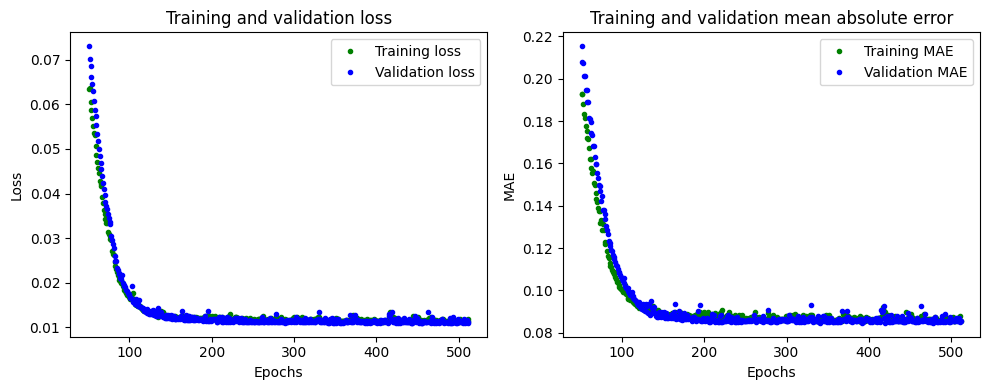

In [56]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

7/7 [==============================] - 0s 667us/step


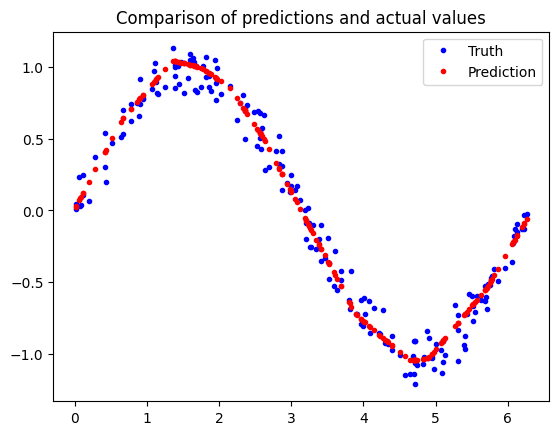

In [52]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Truth')
plt.plot(x_test, y_test_pred, 'r.', label='Prediction')
plt.legend()
plt.show()

# 학습한 Tensorflow 모델을 TFLite 모델 변환

1. TFLite 모델 변환
2. Tensorflow 모델 vs TFLite 모델 예측 비교

## TFLite 모델 변환

In [16]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
# TFLite Int8 Quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

def representative_dataset():
    for i in range(500):
        yield([x_train[i].reshape(1, 1)])
converter.representative_dataset = representative_dataset

# TFLite Model로 변환
model_tflite = converter.convert()

fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [18]:
# TFLite 모델 저장
open(MODEL_TFLITE, "wb").write(model_tflite)

2664

In [21]:
def predict_tflite(tflite_model, x_test):
    # Prepare the test data
    x_test_ = x_test.copy()
    x_test_ = x_test_.reshape((x_test.size, 1))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        #breakpoint()  --> jupyter notebook - local
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    # Invoke the interpreter
    y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred

## Tensorflow 모델 vs TFLite 모델 예측 비교

In [62]:
y_test_pred_tf = model.predict(x_test)
y_test_pred_tf = y_test_pred_tf.reshape(-1)

y_test_pred_tflite = predict_tflite(model_tflite, x_test)

7/7 [==============================] - 0s 862us/step


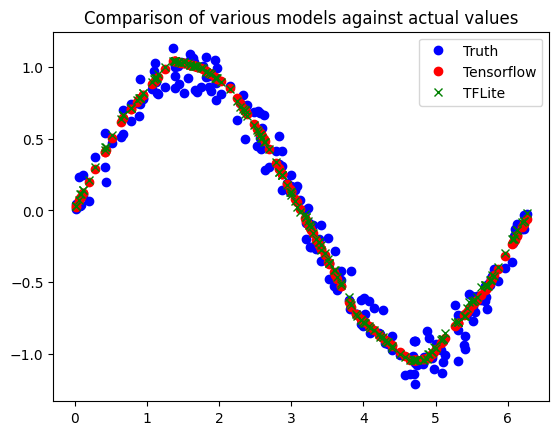

In [38]:
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Truth')
plt.plot(x_test, y_test_pred_tf, 'ro', label='Tensorflow')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite')
plt.legend()
plt.show()

In [74]:
mse = tf.keras.losses.MeanSquaredError()

loss_tf = mse(y_test, y_test_pred_tf).numpy()
loss_tflite = mse(y_test, y_test_pred_tflite).numpy()

pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TFLite", loss_tflite]],
    columns = ["Model", "Loss/MSE"], index="Model").round(4)

,Loss/MSE
Model,
TensorFlow,0.0100
TFLite,0.0105


## TFLite 모델 파일을 C Source 변환

In [15]:
# xxd: 파일 or 표준 입출력을 hex dump 하는 리눅스 표준 유틸리티
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}

In [71]:
!ls -R models

models:
model  model.cc  model.tflite

models/model:
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables

models/model/assets:

models/model/variables:
variables.data-00000-of-00001  variables.index


##### 변환된 모델 파일 확인

In [20]:
!head {MODEL_TFLITE_MICRO}
!echo ".................."
!tail {MODEL_TFLITE_MICRO}

unsigned char models_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x90, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00,
  0xa4, 0x03, 0x00, 0x00, 0xb4, 0x03, 0x00, 0x00, 0x0c, 0x0a, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0a, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
..................
  0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x5d, 0x4f, 0xc9, 0x3c,
  0x1d, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x5f, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x69, 0x6e, 0x70, 0x75, 0x74, 0x3a, 0x3

## 변환된 모델 파일을 사용하는 Target App 개발

 - Tensorflow Lite 공식 example 사용

##### Example 소스코드 확인

In [73]:
!ls tensorflow/tensorflow/lite/micro/examples/hello_world

BUILD			 esp			     output_handler.cc
Makefile.inc		 hello_world_binary_test.sh  output_handler.h
README.md		 hello_world_test.cc	     output_handler_test.cc
arduino			 images			     riscv32_mcu
constants.cc		 main.cc		     sparkfun_edge
constants.h		 main_functions.cc	     tags
create_sine_model.ipynb  main_functions.h	     train
cscope.out		 model.cc		     zephyr_riscv
disco_f746ng		 model.h


##### main.cc

tensorflow/tensorflow/lite/micro/examples/hello_world/main.cc

```
#include "tensorflow/lite/micro/examples/hello_world/main_functions.h"

// This is the default main used on systems that have the standard C entry
// point. Other devices (for example FreeRTOS or ESP32) that have different
// requirements for entry code (like an app_main function) should specialize
// this main.cc file in a target-specific subfolder.

int main(int argc, char* argv[]) {
  setup();
  while (true) {
    loop();
  }
}
```

In [89]:
!cat tensorflow/tensorflow/lite/micro/examples/hello_world/model.cc

/* Copyright 2020 The TensorFlow Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
==============================================================================*/

// Automatically created from a TensorFlow Lite flatbuffer using the command:
// xxd -i model.tflite > model.cc

// This is a standard TensorFlow Lite model file that has been converted into a
// C data array, so it can be easily compiled into a binary for devices that
// don't have a file system.

// See train/README.md for a f

In [112]:
os.chdir('tensorflow')
!pwd
!make -f tensorflow/lite/micro/tools/make/Makefile hello_world
os.chdir('../')

/home/jangwon/tinyml/tensorflow
tensorflow/lite/micro/tools/make/downloads/flatbuffers already exists, skipping the download.
tensorflow/lite/micro/tools/make/downloads/pigweed already exists, skipping the download.
make: 'hello_world'을(를) 위해 할 일이 없습니다.


In [108]:
!ls /tensorflow/lite/micro/tools/make/gen

ls: '/tensorflow/lite/micro/tools/make/gen'에 접근할 수 없습니다: 그런 파일이나 디렉터리가 없습니다


In [1]:
!pwd

/home/jangwon/tinyml


In [3]:
!./tensorflow/tensorflow/lite/micro/tools/make/gen/linux_x86_64_default/bin/hello_world

x_value: 1.0*2^-127, y_value: 1.0*2^-127

x_value: 1.2566366*2^-2, y_value: 1.4910772*2^-2

x_value: 1.2566366*2^-1, y_value: 1.1183078*2^-1

